# Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters
from skimage.morphology import disk, opening
import os
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Sample Image

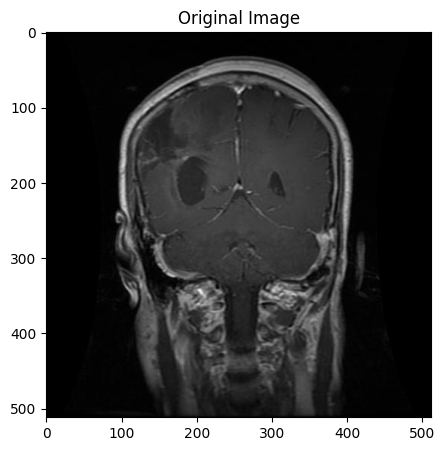

In [2]:
# Path to a sample image (replace if needed; note dataset has 'notumor' not 'no_tumor')
sample_img_path = '/Users/tuhinalambijoy/Downloads/brain_tumor_dataset/Training/glioma/Tr-gl_0010.jpg'

# Load image
img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)

# Output: Original Image
plt.figure(figsize=(5,5))
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.show()

# Description of Change: Image loaded as grayscale. No changes yet.
#  The output shows a raw MRI scan with possible low contrast and noise.

# Image Enhancement

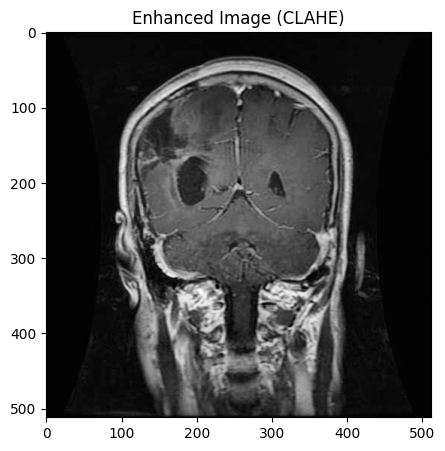

In [3]:
# CLAHE for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced_img = clahe.apply(img)

# Output: Enhanced Image
plt.figure(figsize=(5,5))
plt.imshow(enhanced_img, cmap='gray')
plt.title('Enhanced Image (CLAHE)')
plt.show()

# Description of Change: Contrast is improved,
#  making tumor regions more distinguishable from healthy tissue.
#  Brighter areas are amplified, but noise might increase slightly.

# Noise Removal

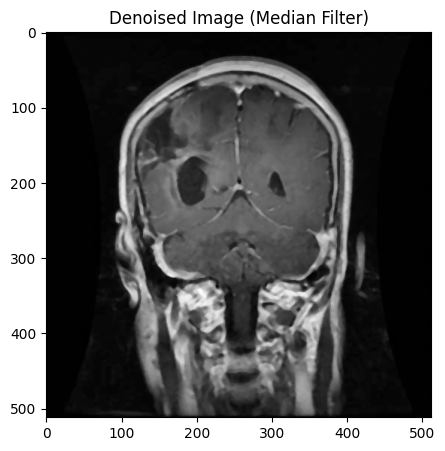

In [4]:
# Median filter for noise removal
denoised_img = cv2.medianBlur(enhanced_img, 5)

# Output: Denoised Image
plt.figure(figsize=(5,5))
plt.imshow(denoised_img, cmap='gray')
plt.title('Denoised Image (Median Filter)')
plt.show()

# Description of Change: Removes speckle noise, smoothing the image while preserving edges.
#  Tumor boundaries remain intact, but fine details might be slightly blurred.

# Edge Detection

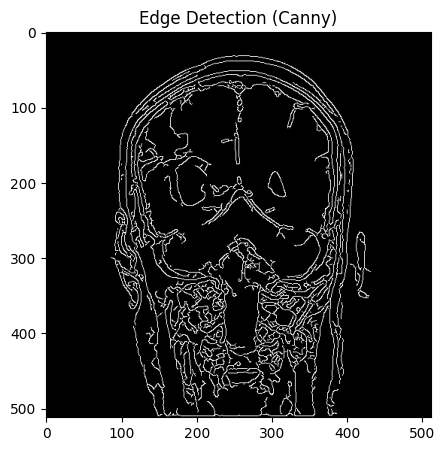

In [5]:
# Canny edge detection
edges = cv2.Canny(denoised_img, 30, 150)

# Output: Edges
plt.figure(figsize=(5,5))
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection (Canny)')
plt.show()

# Description of Change: Highlights boundaries, including tumor edges.
#  White lines indicate strong gradients.

# Segmentation

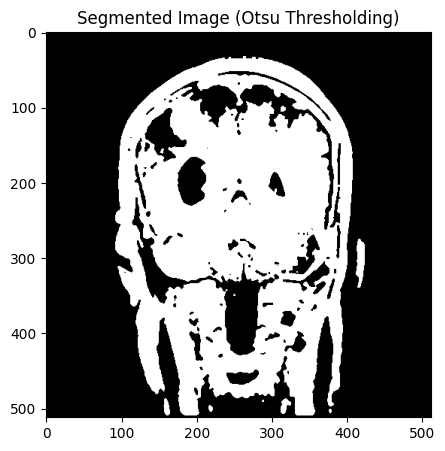

In [6]:
# Otsu's thresholding
thresh_val = filters.threshold_otsu(denoised_img)
segmented_img = denoised_img > thresh_val

# Convert to uint8 for morphology
segmented_img = (segmented_img * 255).astype(np.uint8)

# Output: Segmented Image
plt.figure(figsize=(5,5))
plt.imshow(segmented_img, cmap='gray')
plt.title('Segmented Image (Otsu Thresholding)')
plt.show()

# Description of Change: Binarizes the image,
#  separating foreground (potential tumor) from background. Tumor region appears white.

# Post-Processing

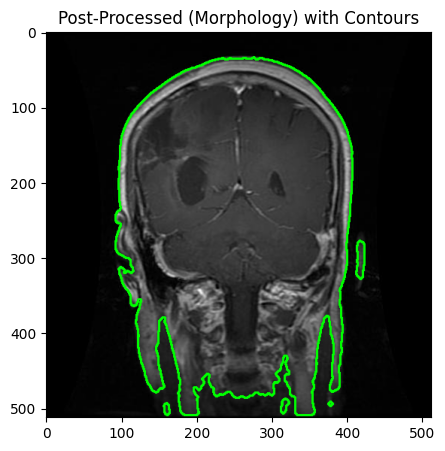

In [7]:
# Morphological opening
kernel = disk(3)
post_processed_img = opening(segmented_img, kernel)

# Find contours
contours, _ = cv2.findContours(post_processed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on original for visualization
contoured_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contoured_img, contours, -1, (0, 255, 0), 2)

# Output: Post-Processed and Contoured Image
plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(contoured_img, cv2.COLOR_BGR2RGB))
plt.title('Post-Processed (Morphology) with Contours')
plt.show()

# Description of Change: Removes small artifacts, smooths the mask. Contours highlight the segmented tumor region.

# CNN Definition and Training

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # For 128x128 input
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, preprocess=True):
        self.root_dir = root_dir
        self.preprocess = preprocess
        self.images = []
        self.labels = []
        classes = ['glioma', 'meningioma', 'notumor', 'pituitary']  # Corrected class names
        for idx, cls in enumerate(classes):
            path = os.path.join(root_dir, cls)
            if os.path.exists(path):
                for img_name in os.listdir(path):
                    self.images.append(os.path.join(path, img_name))
                    self.labels.append(idx)
            else:
                print(f"Warning: Path {path} does not exist.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if self.preprocess:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            img = clahe.apply(img)
            img = cv2.medianBlur(img, 5)
        img = cv2.resize(img, (128, 128))
        img = img.astype(np.float32) / 255.0
        img = torch.from_numpy(img).unsqueeze(0)
        label = self.labels[idx]
        return img, label

def train_cnn(train_dir, test_dir, preprocess=True, epochs=5):
    train_dataset = BrainTumorDataset(train_dir, preprocess=preprocess)
    test_dataset = BrainTumorDataset(test_dir, preprocess=preprocess)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    print(f"Starting training ({'with' if preprocess else 'without'} preprocessing)...")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}')
    
    # Evaluation
    model.eval()
    y_true, y_pred = [], []
    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    proc_time = (time.time() - start_time) / len(test_dataset)
    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    print(f"Evaluation complete -> Accuracy: {acc:.4f}, F1: {f1:.4f}")
    
    return acc, prec, rec, f1, proc_time, model  # Return the trained model too!

# Paths (adjust if needed)
train_dir = '/Users/tuhinalambijoy/Downloads/brain_tumor_dataset/Training'
test_dir = '/Users/tuhinalambijoy/Downloads/brain_tumor_dataset/Testing'

print("=== Training Model WITH Preprocessing ===")
acc_with, prec_with, rec_with, f1_with, time_with, model_with = train_cnn(
    train_dir, test_dir, preprocess=True, epochs=5
)

print("\n=== Training Model WITHOUT Preprocessing ===")
acc_without, prec_without, rec_without, f1_without, time_without, model_without = train_cnn(
    train_dir, test_dir, preprocess=False, epochs=5
)

# Save the trained models for later use (inference on new images)
torch.save(model_with.state_dict(), 'brain_tumor_model_with_preprocess.pth')
torch.save(model_without.state_dict(), 'brain_tumor_model_without_preprocess.pth')

print("\nTraining complete! Models saved.")
print(f"With Preprocessing -> Acc: {acc_with:.4f}, F1: {f1_with:.4f}, Time/img: {time_with:.6f}s")
print(f"Without Preprocessing -> Acc: {acc_without:.4f}, F1: {f1_without:.4f}, Time/img: {time_without:.6f}s")

=== Training Model WITH Preprocessing ===
Starting training (with preprocessing)...
Epoch 1/5, Loss: 0.5283
Epoch 2/5, Loss: 0.2875
Epoch 3/5, Loss: 0.1645
Epoch 4/5, Loss: 0.0933
Epoch 5/5, Loss: 0.0520
Evaluation complete -> Accuracy: 0.9415, F1: 0.9415

=== Training Model WITHOUT Preprocessing ===
Starting training (without preprocessing)...
Epoch 1/5, Loss: 0.6702
Epoch 2/5, Loss: 0.3918
Epoch 3/5, Loss: 0.2857
Epoch 4/5, Loss: 0.2050
Epoch 5/5, Loss: 0.1437
Evaluation complete -> Accuracy: 0.9227, F1: 0.9224

Training complete! Models saved.
With Preprocessing -> Acc: 0.9415, F1: 0.9415, Time/img: 0.002953s
Without Preprocessing -> Acc: 0.9227, F1: 0.9224, Time/img: 0.002406s


# Test a New MRI Image

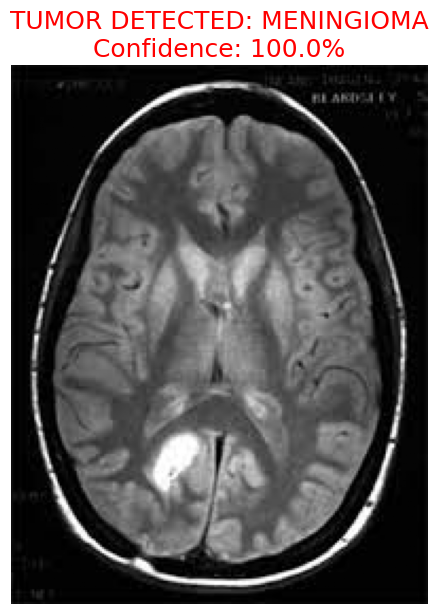

Prediction: meningioma (confidence: 100.0%)


In [9]:
def predict_new_mri(image_path, use_preprocessing=True):
    model_path = 'brain_tumor_model_with_preprocess.pth' if use_preprocessing else 'brain_tumor_model_without_preprocess.pth'
    
    model = SimpleCNN().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Image not found. Check the path.")
        return None
    
    if use_preprocessing:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
        img = cv2.medianBlur(img, 5)
    
    img = cv2.resize(img, (128, 128))
    img = img.astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
    prediction = classes[predicted.item()]
    conf = confidence.item()
    
    plt.figure(figsize=(7,7))
    plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
    if prediction == 'notumor':
        plt.title(f'NO TUMOR DETECTED\nConfidence: {conf:.1%}', color='green', fontsize=18)
    else:
        plt.title(f'TUMOR DETECTED: {prediction.upper()}\nConfidence: {conf:.1%}', color='red', fontsize=18)
    plt.axis('off')
    plt.show()
    
    return prediction, conf

# === TEST A NEW IMAGE ===
new_image_path = '/Users/tuhinalambijoy/Desktop/images (1).jpeg'  # CHANGE THIS TO YOUR ACTUAL IMAGE PATH

result, confidence = predict_new_mri(new_image_path, use_preprocessing=True)
if result:
    print(f"Prediction: {result} (confidence: {confidence:.1%})")

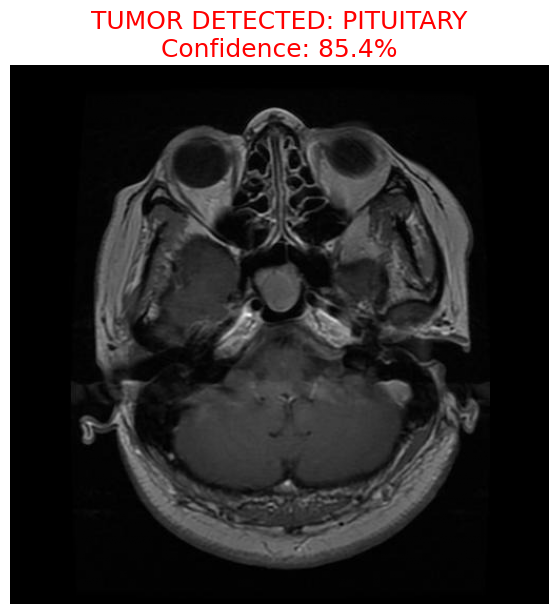

Prediction: pituitary (confidence: 85.4%)


In [10]:

def predict_new_mri(image_path, use_preprocessing=True):
    model_path = 'brain_tumor_model_with_preprocess.pth' if use_preprocessing else 'brain_tumor_model_without_preprocess.pth'
    
    model = SimpleCNN().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Image not found. Check the path.")
        return None
    
    if use_preprocessing:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
        img = cv2.medianBlur(img, 5)
    
    img = cv2.resize(img, (128, 128))
    img = img.astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
    prediction = classes[predicted.item()]
    conf = confidence.item()
    
    plt.figure(figsize=(7,7))
    plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
    if prediction == 'notumor':
        plt.title(f'NO TUMOR DETECTED\nConfidence: {conf:.1%}', color='green', fontsize=18)
    else:
        plt.title(f'TUMOR DETECTED: {prediction.upper()}\nConfidence: {conf:.1%}', color='red', fontsize=18)
    plt.axis('off')
    plt.show()
    
    return prediction, conf

# === TEST A NEW IMAGE ===
new_image_path = '/Users/tuhinalambijoy/Downloads/brain_tumor_dataset/Testing/pituitary/Te-pi_0043.jpg'  # CHANGE THIS TO YOUR ACTUAL IMAGE PATH

result, confidence = predict_new_mri(new_image_path, use_preprocessing=True)
if result:
    print(f"Prediction: {result} (confidence: {confidence:.1%})")